# Aikidoka: AwdLstm
Averaged Stochastic Gradient Descent Weight-Dropped LSTM model inspired by https://arxiv.org/abs/1708.02182.

In [1]:
import os
import sys
sys.path.append(os.path.realpath('..'))

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

Load the Embedding class in order to convert tokens to vectors.

In [2]:
from aikido.nn.modules.embedding import BPEmbEmbedding
embedding = BPEmbEmbedding("de")

Load the CSV data and preprocess it with spacy.

In [3]:
from aikido.kata import CsvKata
from aikido.kata.preprocessor import SpacyPreprocessor

preprocessor = SpacyPreprocessor("de_core_news_sm", stem=True)
kata = CsvKata.from_file('./train.csv', embedding, preprocessor=preprocessor, max_text_len=150)
kata_train, kata_val = kata.split(0.8)
kata_test = CsvKata.from_file('./test.csv', embedding, preprocessor=preprocessor, max_text_len=150)

Initialize the Averaged Stochastic Gradient Descent Weight-Dropped LSTM model.

In [4]:
from aikido.aikidoka.classification import AwdLstm, AwdLstmKun

aikidokaKun = AwdLstmKun(embedding, hidden_layers=4, hidden_size=128)
aikidoka = AwdLstm(aikidokaKun)

Prepare the dojo for the aikidoka model.
Configure the optimizer as well as the learning rate scheduler.
Enable the LiveLossPlotListener in order to visualize the training accuracy.

In [5]:
from aikido.dojo.listener import LiveLossPlotListener
from aikido.dojo.listener import LearningRateStepListener
from aikido.dojo.listener import TqdmListener
from aikido.dojo import RnnDojo, RnnDojoKun
import torch
from torch import nn

optimizer = torch.optim.AdamW(aikidoka.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9)
loss = nn.CrossEntropyLoss()

dojoKun = RnnDojoKun(optimizer, loss, dans=20)
dojo = RnnDojo(dojoKun)
dojo.add_listener(LiveLossPlotListener())
dojo.add_listener(LearningRateStepListener(scheduler))
dojo.add_listener(DeepSpeedListener())

Train the aikidoka.

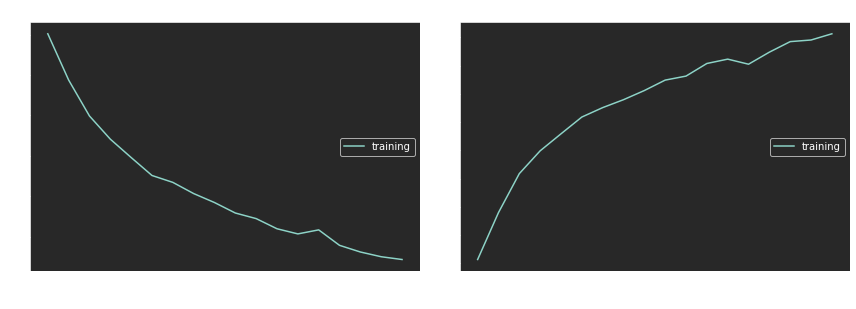

loss:
training   (min:    0.443, max:    1.776, cur:    0.443)

train_acc:
training   (min:   32.708, max:   85.319, cur:   85.319)


In [6]:
dojo.train(aikidoka, kata_train)

Evaluate the aikidoka and visualize the results.

In [11]:
evaluation = dojo.evaluate(aikidoka, kata_val, probability=False)

In [12]:
from aikido.visuals import AccuracyScore
# AccuracyScore().render(evaluation)
evaluation.visualize(AccuracyScore())

XyzAdapter(aikidoka)

0.8747731397459165


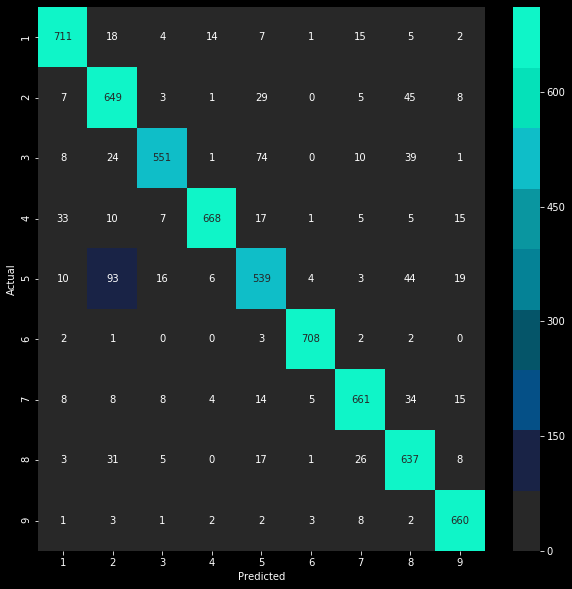

In [13]:
from aikido.visuals import ConfusionMatrix
ConfusionMatrix().render(evaluation)